<a href="https://colab.research.google.com/github/kamalsinha7305/SOH-prediction-for-EV-vehicals-battery-/blob/main/Soh_for_EV_vehicals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  # train_gan_soh_with_train_test.py
  import os
  import numpy as np
  import pandas as pd
  import torch
  import torch.nn as nn
  from torch.utils.data import DataLoader, TensorDataset
  import matplotlib.pyplot as plt


In [ ]:

  # -------------------------
  # Models (unchanged logic)
  # -------------------------
  class Generator(nn.Module):
      def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
          super(Generator, self).__init__()
          self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                              num_layers=num_layers, batch_first=True, dropout=dropout)
          self.fc = nn.Sequential(
              nn.LayerNorm(hidden_size),
              nn.Linear(hidden_size, hidden_size // 2),
              nn.ReLU(),
              nn.Linear(hidden_size // 2, output_size)
          )

      def forward(self, x):
          lstm_out, _ = self.lstm(x)          # (batch, seq_len, hidden_size)
          out = self.fc(lstm_out)             # (batch, seq_len, output_size)
          return out


In [ ]:
class Discriminator(nn.Module):
      def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.3):
          super(Discriminator, self).__init__()
          self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                              num_layers=num_layers, batch_first=True, dropout=dropout)
          self.fc = nn.Sequential(
              nn.LayerNorm(hidden_size),
              nn.Linear(hidden_size, hidden_size // 2),
              nn.LeakyReLU(0.2),
              nn.Linear(hidden_size // 2, 1),
              nn.Sigmoid()
          )

      def forward(self, x):
          lstm_out, _ = self.lstm(x)
          final_state = lstm_out[:, -1, :]  # use last time step (batch, hidden_size)
          out = self.fc(final_state)        # (batch, 1)
          return out


In [ ]:

  # -------------------------
  # Data prep (build sequences, then split, then normalize on TRAIN only)
  # -------------------------
  def prepare_sequences_from_csv(csv_path, t_in=100, t_out=100, stride=10, create_synthetic_soh=True):
      """
      Loads CSV, optionally creates SoH_true, builds raw (unnormalized) X and Y sequences.
      Returns:
          X_np: ndarray (num_sequences, t_in, features)
          Y_np: ndarray (num_sequences, t_out, 1)
      """
      df = pd.read_csv(csv_path)

      required_columns = ['Battery Current (A):1', 'Battery Voltage (V):1', 'Battery Power (Kw):1', 'SOC:1']
      for c in required_columns:
          if c not in df.columns:
              raise ValueError(f"Missing required column in CSV: {c}")

      # Create synthetic SoH if not present
      if 'SoH_true' not in df.columns:
          if not create_synthetic_soh:
              raise ValueError("SoH_true column not found and create_synthetic_soh is False.")
          v_max = df['Battery Voltage (V):1'].max()
          if v_max == 0 or np.isnan(v_max):
              v_norm = df['Battery Voltage (V):1']
          else:
              v_norm = df['Battery Voltage (V):1'] / v_max * 100.0

          soh = 0.6 * df['SOC:1'].fillna(0) + 0.4 * v_norm.fillna(0)
          soh = soh.clip(0.0, 100.0) + np.random.normal(0, 0.01, size=len(soh))
          df['SoH_true'] = soh

      df = df[required_columns + ['SoH_true']].dropna().reset_index(drop=True)

      features = df[required_columns].astype(float).values  # shape (T, features)
      target = df['SoH_true'].astype(float).values         # shape (T,)

      if t_in != t_out:
          raise ValueError("This implementation assumes t_in == t_out. Set t_in == t_out (e.g. 100).")

      X_list = []
      Y_list = []
      total = len(df)
      for i in range(0, total - t_in - t_out + 1, stride):
          x_seq = features[i:i+t_in]          # (t_in, features)
          y_seq = target[i+t_in:i+t_in+t_out].reshape(-1, 1)  # (t_out, 1)
          X_list.append(x_seq)
          Y_list.append(y_seq)

      X_np = np.array(X_list, dtype=np.float32)
      Y_np = np.array(Y_list, dtype=np.float32)

      return X_np, Y_np


  def train_test_split_sequences(X, Y, train_ratio=0.8, seed=42):
      """
      Simple reproducible shuffle split for sequences.
      Returns: X_train, X_test, Y_train, Y_test
      """
      np.random.seed(seed)
      n = len(X)
      if n == 0:
          raise ValueError("No sequences produced. Check CSV, t_in/t_out/stride.")
      idx = np.arange(n)
      np.random.shuffle(idx)
      split = int(n * train_ratio)
      train_idx = idx[:split]
      test_idx = idx[split:]
      X_train = X[train_idx]
      Y_train = Y[train_idx]
      X_test = X[test_idx]
      Y_test = Y[test_idx]
      return X_train, X_test, Y_train, Y_test


  def normalize_by_train_stats(X_train, X_test):
      """
      Compute mean/std on training set (over seq/time) per feature and normalize both train & test.
      """
      # Flatten (num_seq * seq_len, features) then compute mean/std
      flat = X_train.reshape(-1, X_train.shape[-1])
      mean = flat.mean(axis=0)
      std = flat.std(axis=0)
      std_replaced = np.where(std == 0, 1.0, std)
      X_train_norm = (X_train - mean) / std_replaced
      X_test_norm = (X_test - mean) / std_replaced
      return X_train_norm.astype(np.float32), X_test_norm.astype(np.float32), mean.astype(np.float32), std_replaced.astype(np.float32)


In [ ]:


  # -------------------------
  # Hyperparams / config
  # -------------------------
  EPOCHS = 200
  BATCH_SIZE = 64
  LR = 5e-5
  T_IN = 100
  T_OUT = 100   # t_in == t_out
  FEATURES = 4

  TRAIN_RATIO = 0.8
  SEED = 42

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(SEED)
  np.random.seed(SEED)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(SEED)

  # Input CSV
  use_csv = True
  csv_path = "batttry.csv"   # change if needed

  # -------------------------
  # Load & prepare data, split, normalize using train stats
  # -------------------------
  if use_csv:
      X_all, Y_all = prepare_sequences_from_csv(csv_path, t_in=T_IN, t_out=T_OUT, stride=10, create_synthetic_soh=True)
  else:
      X_all = np.load('data/X_seq_true.npy')
      Y_all = np.load('data/Y_seq_true.npy')

  print(f"Total sequences: {len(X_all)}")

  X_train_np, X_test_np, Y_train_np, Y_test_np = train_test_split_sequences(X_all, Y_all, train_ratio=TRAIN_RATIO, seed=SEED)
  X_train_np, X_test_np, feat_mean, feat_std = normalize_by_train_stats(X_train_np, X_test_np)

  # Convert to tensors
  X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
  Y_train_tensor = torch.tensor(Y_train_np, dtype=torch.float32)
  X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
  Y_test_tensor = torch.tensor(Y_test_np, dtype=torch.float32)

  print(f"Train shapes — X: {X_train_tensor.shape}, Y: {Y_train_tensor.shape}")
  print(f"Test  shapes — X: {X_test_tensor.shape}, Y: {Y_test_tensor.shape}")

  train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
  test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  # -------------------------
  # Models, loss, optim (same as your original)
  # -------------------------
  generator = Generator(input_size=FEATURES, hidden_size=128, output_size=1).to(device)
  discriminator = Discriminator(input_size=1, hidden_size=64).to(device)

  adversarial_loss = nn.BCELoss()
  regression_loss = nn.MSELoss()
  mae_loss = nn.L1Loss()  # for optional MAE metric

  g_optimizer = torch.optim.Adam(generator.parameters(), lr=LR)
  d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LR)

  os.makedirs('checkpoints', exist_ok=True)

  # -------------------------
  # Training loop with evaluation on test set each epoch
  # -------------------------
  for epoch in range(EPOCHS):
      generator.train()
      discriminator.train()
      running_d_loss = 0.0
      running_g_loss = 0.0
      for i, (real_X, real_Y) in enumerate(train_loader):
          real_X = real_X.to(device)   # (batch, seq, features)
          real_Y = real_Y.to(device)   # (batch, seq, 1)

          # Generate fake Y from generator
          fake_Y = generator(real_X)   # (batch, seq, 1)

          # ---------------------
          # Train Discriminator
          # ---------------------
          d_optimizer.zero_grad()
          real_labels = torch.ones((real_Y.size(0), 1), device=device)
          fake_labels = torch.zeros((real_Y.size(0), 1), device=device)

          d_real = discriminator(real_Y)            # (batch, 1)
          d_fake = discriminator(fake_Y.detach())   # (batch, 1)

          d_loss_real = adversarial_loss(d_real, real_labels)
          d_loss_fake = adversarial_loss(d_fake, fake_labels)
          d_loss = d_loss_real + d_loss_fake
          d_loss.backward()
          d_optimizer.step()

          # ---------------------
          # Train Generator
          # ---------------------
          g_optimizer.zero_grad()
          fake_Y = generator(real_X)
          d_fake_for_g = discriminator(fake_Y)

          g_adv_loss = adversarial_loss(d_fake_for_g, real_labels)  # generator wants discriminator to say "real"
          g_mse_loss = regression_loss(fake_Y, real_Y)              # match the true SoH trajectory
          g_loss =  0.2 * g_adv_loss + 0.8 * g_mse_loss
          g_loss.backward()
          g_optimizer.step()

          running_d_loss += d_loss.item()
          running_g_loss += g_loss.item()

      avg_d_loss = running_d_loss / (i+1)
      avg_g_loss = running_g_loss / (i+1)

      # Evaluate generator on test set (MSE + MAE)
      generator.eval()
      test_mse = 0.0
      test_mae = 0.0
      with torch.no_grad():
          for j, (tx, ty) in enumerate(test_loader):
              tx = tx.to(device)
              ty = ty.to(device)
              pred = generator(tx)
              test_mse += regression_loss(pred, ty).item()
              test_mae += mae_loss(pred, ty).item()
      test_mse /= (j+1)
      test_mae /= (j+1)

      print(f"Epoch [{epoch+1}/{EPOCHS}] | D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f} (last batch Adv: {g_adv_loss.item():.4f}, MSE: {g_mse_loss.item():.4f}) | Test MSE: {test_mse:.6f} | Test MAE: {test_mae:.6f}")

      # save checkpoint each epoch (or every few epochs)
      torch.save(generator.state_dict(), f'checkpoints/generator_epoch{epoch+1}.pth')


Total sequences: 23025
Train shapes — X: torch.Size([18420, 100, 4]), Y: torch.Size([18420, 100, 1])
Test  shapes — X: torch.Size([4605, 100, 4]), Y: torch.Size([4605, 100, 1])
Epoch [1/200] | D Loss: 0.6402 | G Loss: 4009.9208 (last batch Adv: 3.1614, MSE: 3909.0908) | Test MSE: 4369.284492 | Test MAE: 64.100313
Epoch [2/200] | D Loss: 0.1196 | G Loss: 2994.1007 (last batch Adv: 4.3703, MSE: 3144.9277) | Test MSE: 2997.005598 | Test MAE: 52.311717
Epoch [3/200] | D Loss: 0.0456 | G Loss: 1859.1762 (last batch Adv: 5.1345, MSE: 1884.5116) | Test MSE: 1638.514806 | Test MAE: 37.123587
Epoch [4/200] | D Loss: 0.2517 | G Loss: 921.2776 (last batch Adv: 2.6543, MSE: 715.5886) | Test MSE: 727.857485 | Test MAE: 22.446606
Epoch [5/200] | D Loss: 0.5834 | G Loss: 405.7273 (last batch Adv: 2.6244, MSE: 435.3989) | Test MSE: 351.767354 | Test MAE: 15.678153
Epoch [6/200] | D Loss: 0.4558 | G Loss: 219.3692 (last batch Adv: 2.4525, MSE: 209.5099) | Test MSE: 155.769231 | Test MAE: 8.380951
Epoch

In [ ]:

  # final save
  torch.save(generator.state_dict(), 'checkpoints/generator_final.pth')
  print("Training complete. Checkpoints saved in ./checkpoints")




Training complete. Checkpoints saved in ./checkpoints



=== Sample SoH Predictions (first 10 test sequences) ===
Sample 1:
True SoH (first 5 timesteps): [48.85 48.83 48.83 48.83 48.85]
Pred SoH  (first 5 timesteps): [49.28 49.11 49.07 49.08 49.08]

Sample 2:
True SoH (first 5 timesteps): [53.93 53.92 53.95 53.95 53.95]
Pred SoH  (first 5 timesteps): [53.87 53.8  53.78 53.8  53.83]

Sample 3:
True SoH (first 5 timesteps): [71.05 71.05 71.04 71.05 71.05]
Pred SoH  (first 5 timesteps): [71.04 71.08 71.03 71.01 71.03]

Sample 4:
True SoH (first 5 timesteps): [48.57 48.56 48.56 48.58 48.58]
Pred SoH  (first 5 timesteps): [48.16 48.02 48.03 48.07 48.1 ]

Sample 5:
True SoH (first 5 timesteps): [51.61 51.62 51.63 51.62 51.63]
Pred SoH  (first 5 timesteps): [52.17 51.97 51.89 51.87 51.86]

Sample 6:
True SoH (first 5 timesteps): [71.47 71.48 71.48 71.48 71.46]
Pred SoH  (first 5 timesteps): [71.47 71.51 71.47 71.47 71.5 ]

Sample 7:
True SoH (first 5 timesteps): [98.8  98.81 98.81 98.79 98.8 ]
Pred SoH  (first 5 timesteps): [99.64 99.49 99.13 98.9

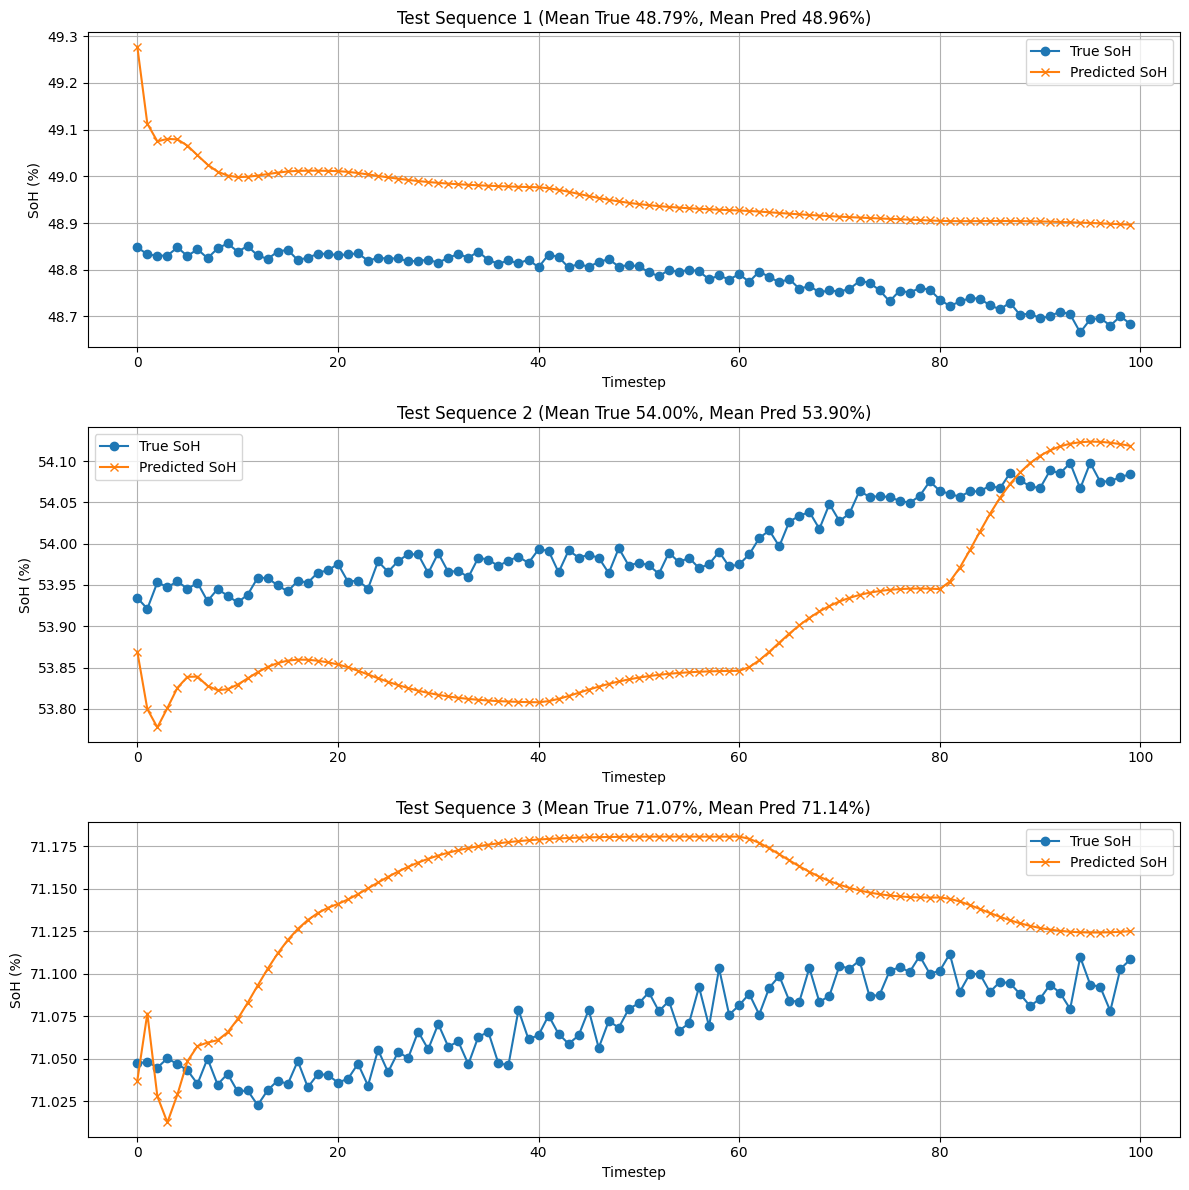

In [ ]:
# -------------------------
# After training — Test on first few test samples and plot
# -------------------------
generator.eval()
with torch.no_grad():
    sample_count = min(10, X_test_tensor.shape[0])
    if sample_count == 0:
        print("No test samples to evaluate/plot. Exiting.")
    else:
        sample_X = X_test_tensor[:sample_count].to(device)  # shape: (sample_count, seq_len, features)
        sample_Y_true = Y_test_tensor[:sample_count].cpu().numpy()
        sample_Y_pred = generator(sample_X).cpu().numpy()

        print("\n=== Sample SoH Predictions (first {} test sequences) ===".format(sample_count))
        for i in range(sample_count):
            print(f"Sample {i+1}:")
            print("True SoH (first 5 timesteps):", np.round(sample_Y_true[i][:5].flatten(), 2))
            print("Pred SoH  (first 5 timesteps):", np.round(sample_Y_pred[i][:5].flatten(), 2))
            print()

        # Mean per-sequence comparison
        mean_true_soh = sample_Y_true.mean(axis=1).flatten()
        mean_pred_soh = sample_Y_pred.mean(axis=1).flatten()
        print("=== Mean SoH per sequence (True vs Pred) ===")
        for i in range(len(mean_true_soh)):
            print(f"Seq {i+1}: True={mean_true_soh[i]:.2f}% | Pred={mean_pred_soh[i]:.2f}%")

        # Compute overall RMSE and MAE on entire test set
        all_preds = []
        all_trues = []
        with torch.no_grad():
            for tx, ty in test_loader:
                tx = tx.to(device)
                all_preds.append(generator(tx).cpu().numpy())
                all_trues.append(ty.cpu().numpy())
        all_preds = np.concatenate(all_preds, axis=0)
        all_trues = np.concatenate(all_trues, axis=0)
        mse_overall = np.mean((all_preds - all_trues)**2)
        rmse_overall = np.sqrt(mse_overall)
        mae_overall = np.mean(np.abs(all_preds - all_trues))
        print(f"\nTest RMSE: {rmse_overall:.4f} | Test MAE: {mae_overall:.4f}")

        # Plot (first 3 sequences)
        num_plots = min(3, sample_count)
        plt.figure(figsize=(12, 4 * num_plots))
        for i in range(num_plots):
            plt.subplot(num_plots, 1, i+1)
            plt.plot(sample_Y_true[i].flatten(), label='True SoH', marker='o')
            plt.plot(sample_Y_pred[i].flatten(), label='Predicted SoH', marker='x')
            plt.title(f"Test Sequence {i+1} (Mean True {mean_true_soh[i]:.2f}%, Mean Pred {mean_pred_soh[i]:.2f}%)")
            plt.xlabel("Timestep")
            plt.ylabel("SoH (%)")
            plt.legend()
            plt.grid(True)
        plt.tight_layout()
        plt.show()